# step1 모델링 재무 + text1단계 + 시장데이터

In [51]:
import pandas as pd
import numpy as np
from tqdm import tqdm 

import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
plt.rcParams['font.family'] = 'malgun gothic'

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss, plot_confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier, Pool  
from lightgbm import LGBMClassifier   
from sklearn.neural_network import MLPClassifier

from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler

import warnings
warnings.filterwarnings(action='ignore')

## 함수

In [ ]:
def modeling(model, X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=46)
    cc = RandomUnderSampler(random_state=42) #train만 언더샘플링 진행
    X_train_under, y_train_under = cc.fit_resample(X_train, y_train)
    clf=model

    clf.fit(X_train_under, y_train_under)
    y_pred = clf.predict(X_test)
    y_true = y_test
    print(confusion_matrix(y_true, y_pred)) #confusion_matrix
    print('Accuracy score : ', accuracy_score(y_true, y_pred))
    print('Recall score : ', recall_score(y_true, y_pred, average='macro')) # 스코어
    print('precision score : ', precision_score(y_true, y_pred, average='macro'))
    print('f1_score : ', f1_score(y_true, y_pred, average='macro'))
    print("roc_auc_score: {:.3f}".format(roc_auc_score(y_test, y_pred)))
    #print("pr_auc_score: {:.3f}".format(average_precision_score(y_test, y_pred)))
    feat_importances = pd.Series(clf.feature_importances_ , index= X_train.columns)
    print(feat_importances.plot(kind = 'barh')) #feature_importances

In [44]:
def modeling(model, X, y, test):    
    model.fit(X, y)
    pred = model.predict_proba(test)
    pred = (pred[:,0] < 0.5)*1         # threshold 부도기업일 확률이 10% 이상이면 부도로 판단해라.
    return pred

In [45]:
def scoring(y_true, y_pred):
    print('accuracy:', accuracy_score(y_true,y_pred))
    print('f1-Score:', f1_score(y_true, y_pred, average='macro'))
    print('Recall:',recall_score(y_true, y_pred, average='macro'))
    print('Precision:',precision_score(y_true, y_pred, average='macro'))
    print(confusion_matrix(y_true, y_pred))
    

## 데이터 불러오기

In [6]:
#lasso+anova 겹치는 16개변수
col_16 = ['EBITDA단기차입비율', '경영자본순이익률','당좌비율', '매출채권회수기간', '부가가치율',
            '부채구성비율','부채비율','비유동비율','비유동장기적합률',
            '설비투자효율','순운전자본비율','유동부채비율','자기자본순이익률','재고자산보유기간',
            '총자본순이익률','총자본투자효율']

In [7]:
col_head = ['회사명', '거래소코드', '회계년도']
col_finance = ['설비투자효율', '총자본투자효율', '부채구성비율', '비유동장기적합률',
       '재고자산보유기간', '매출채권회수기간', '매입채무회전률', '경영자본회전률', '경영자본순이익률', '자기자본순이익률',
       '자기자본증가율']
col_text = ['대표이사_변경', '최대주주_변경', '회계처리위반', '횡령배임', '신종채권', '영업조업중단', '종가변동률']
col_tail = ['년', 'key', '부도']

## set2. step1. 1 year ago

In [38]:
step1_y0 = pd.read_csv(r'..\..\..\Data\year 조정 데이터\0y_finan+step1.csv')
step1_y1 = pd.read_csv(r'..\..\..\Data\year 조정 데이터\1y_finan+step1.csv')
step1_y2 = pd.read_csv(r'..\..\..\Data\year 조정 데이터\2y_finan+step1.csv')
step1_y3 = pd.read_csv(r'..\..\..\Data\year 조정 데이터\3y_finan+step1.csv')
step1_y4 = pd.read_csv(r'..\..\..\Data\year 조정 데이터\4y_finan+step1.csv')
col_drop = ['회사명', '거래소코드', '회계년도','년', 'key', '부도']

In [39]:
print(step1_y0.shape)
print(step1_y1.shape)
print(step1_y2.shape)
print(step1_y3.shape)
print(step1_y4.shape)

(26832, 24)
(26832, 24)
(26832, 24)
(26832, 24)
(26832, 24)


In [40]:
def split_train(data):
    
    a = data.loc[data['년'] < 2015].reset_index(drop=True)
    return a

def split_test(data):
    
    a = data.loc[data['년'] >= 2015].reset_index(drop=True)
    return a

In [41]:
test_y0 = split_test(step1_y0)
data_y0 = split_train(step1_y0)
test_y1 = split_test(step1_y1)
data_y1 = split_train(step1_y1)
test_y2 = split_test(step1_y2)
data_y2 = split_train(step1_y2)
test_y3 = split_test(step1_y3)
data_y3 = split_train(step1_y3)
test_y4 = split_test(step1_y4)
data_y4 = split_train(step1_y4)
print(test_y2.shape)
print(test_y3.shape)
print(data_y2.shape)
print(data_y3.shape)

(8504, 24)
(8504, 24)
(18328, 24)
(18328, 24)


In [90]:
# def test_split(data1, data2, data3, data4):
#     data1.loc[data1['회계년도'].str[:4].astype(int)>=2019].reset_index().to_csv('{year}_test.csv'.format(year = data1))
#     data1.loc[data1['회계년도'].str[:4].astype(int)<2019].reset_index().to_csv('{data1}_data.csv'.format(data1))
#     data2.loc[data2['회계년도'].str[:4].astype(int)>=2019].reset_index().to_csv('{data2}_test.csv'.format(data2))
#     data2.loc[data2['회계년도'].str[:4].astype(int)<2019].reset_index().to_csv('{data2}_data.csv'.format(data2))
#     data3.loc[data3['회계년도'].str[:4].astype(int)>=2019].reset_index().to_csv('{data3}_test.csv'.format(data3))
#     data3.loc[data3['회계년도'].str[:4].astype(int)<2019].reset_index().to_csv('{data3}_data.csv'.format(data3))
#     data4.loc[data4['회계년도'].str[:4].astype(int)>=2019].reset_index().to_csv('{data4}_test.csv'.format(data4))
#     data4.loc[data4['회계년도'].str[:4].astype(int)<2019].reset_index().to_csv('{data4}_data.csv'.format(data4))

In [42]:
X = data_y0.drop(col_drop,axis=1)
X1 = data_y1.drop(col_drop,axis=1)
X2 = data_y2.drop(col_drop,axis=1)
X3 = data_y3.drop(col_drop,axis=1)
X4 = data_y4.drop(col_drop,axis=1)

y = data_y0['부도']
y1 = data_y1['부도']
y2 = data_y2['부도']
y3 = data_y3['부도']
y4 = data_y4['부도']

In [43]:
X_test = test_y0.drop(col_drop,axis=1)
X1_test = test_y1.drop(col_drop,axis=1)
X2_test = test_y2.drop(col_drop,axis=1)
X3_test = test_y3.drop(col_drop,axis=1)
X4_test = test_y4.drop(col_drop,axis=1)

y_test = test_y0['부도']
y1_test = test_y1['부도']
y2_test = test_y2['부도']
y3_test = test_y3['부도']
y4_test = test_y4['부도']

## year0

In [49]:
X_train , y_train = RandomUnderSampler(random_state=0).fit_resample(X , y) #언더샘플링

In [52]:
dt_clf = modeling(DecisionTreeClassifier(), X_train, y_train, X_test)
rf_clf = modeling(RandomForestClassifier(),X_train, y_train, X_test)
ada_clf = modeling(AdaBoostClassifier(), X_train, y_train, X_test)
lg_clf = modeling(LogisticRegression(), X_train, y_train, X_test)
knn_clf = modeling(KNeighborsClassifier(), X_train, y_train, X_test)
svc_clf = modeling(SVC(probability=True), X_train, y_train, X_test)
lgmb_clf = modeling(LGBMClassifier(), X_train, y_train, X_test)
cat_clf = modeling(CatBoostClassifier(silent=True),X_train, y_train, X_test)
mlp_clf = modeling(MLPClassifier(),X_train, y_train, X_test)
xgb_clf = modeling(XGBClassifier(),X_train, y_train, X_test)

[17:48:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [53]:
scoring(y_test , cat_clf)

accuracy: 0.823612417685795
f1-Score: 0.4843062706513993
Recall: 0.9112531061412851
Precision: 0.5170637475853187
[[6951 1500]
 [   0   53]]


In [54]:
scoring(y_test , mlp_clf)

accuracy: 0.8225540921919097
f1-Score: 0.47623993037612544
Recall: 0.7888482550909461
Precision: 0.5120879975124378
[[6955 1496]
 [  13   40]]


In [55]:
scoring(y_test , lgmb_clf)

accuracy: 0.8233772342427094
f1-Score: 0.4841939652387413
Recall: 0.9111347769494734
Precision: 0.5170418006430868
[[6949 1502]
 [   0   53]]


In [56]:
scoring(y_test , knn_clf)

accuracy: 0.8410159924741298
f1-Score: 0.48322168405231153
Recall: 0.7793875013116679
Precision: 0.5127661408587204
[[7114 1337]
 [  15   38]]


In [57]:
scoring(y_test , rf_clf)

accuracy: 0.8233772342427094
f1-Score: 0.4841939652387413
Recall: 0.9111347769494734
Precision: 0.5170418006430868
[[6949 1502]
 [   0   53]]


# 1 year ago

In [58]:
X1_train , y1_train = RandomUnderSampler(random_state=0).fit_resample(X1 , y1)

In [59]:
dt_clf1 = modeling(DecisionTreeClassifier(), X1_train, y1_train, X1_test)
rf_clf1 = modeling(RandomForestClassifier(),X1_train, y1_train, X1_test)
ada_clf1 = modeling(AdaBoostClassifier(), X1_train, y1_train, X1_test)
lg_clf1 = modeling(LogisticRegression(), X1_train, y1_train, X1_test)
knn_clf1 = modeling(KNeighborsClassifier(), X1_train, y1_train, X1_test)
svc_clf1 = modeling(SVC(probability=True), X1_train, y1_train, X1_test)
lgmb_clf1 = modeling(LGBMClassifier(), X1_train, y1_train, X1_test)
cat_clf1 = modeling(CatBoostClassifier(silent=True),X1_train, y1_train, X1_test)
mlp_clf1 = modeling(MLPClassifier(),X1_train, y1_train, X1_test)
xgb_clf1 = modeling(XGBClassifier(),X1_train, y1_train, X1_test)

[17:51:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [60]:
scoring(y1_test , cat_clf1)

accuracy: 0.7189557855126999
f1-Score: 0.4336151988924535
Recall: 0.7654623935666982
Precision: 0.5073182062692553
[[6075 2381]
 [   9   39]]


## 2 years ago

In [63]:
X2_train , y2_train = RandomUnderSampler(random_state=0).fit_resample(X2 , y2)

In [64]:
dt_clf2 = modeling(DecisionTreeClassifier(), X2_train, y2_train, X2_test)
rf_clf2 = modeling(RandomForestClassifier(),X2_train, y2_train, X2_test)
ada_clf2 = modeling(AdaBoostClassifier(), X2_train, y2_train, X2_test)
lg_clf2 = modeling(LogisticRegression(), X2_train, y2_train, X2_test)
knn_clf2 = modeling(KNeighborsClassifier(), X2_train, y2_train, X2_test)
svc_clf2 = modeling(SVC(probability=True), X2_train, y2_train, X2_test)
lgmb_clf2 = modeling(LGBMClassifier(), X2_train, y2_train, X2_test)
cat_clf2 = modeling(CatBoostClassifier(silent=True),X2_train, y2_train, X2_test)
mlp_clf2 = modeling(MLPClassifier(),X2_train, y2_train, X2_test)
xgb_clf2 = modeling(XGBClassifier(),X2_train, y2_train, X2_test)

[17:54:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [65]:
scoring(y2_test , cat_clf2)

accuracy: 0.7107243650047037
f1-Score: 0.4277569959704156
Recall: 0.7109167093562412
Precision: 0.5053753772351655
[[6012 2447]
 [  13   32]]


## 3 years ago

In [66]:
X3_train , y3_train = RandomUnderSampler(random_state=0).fit_resample(X3 , y3)

dt_clf3 = modeling(DecisionTreeClassifier(), X3_train, y3_train, X3_test)
rf_clf3 = modeling(RandomForestClassifier(),X3_train, y3_train, X3_test)
ada_clf3 = modeling(AdaBoostClassifier(), X3_train, y3_train, X3_test)
lg_clf3 = modeling(LogisticRegression(), X3_train, y3_train, X3_test)
knn_clf3 = modeling(KNeighborsClassifier(), X3_train, y3_train, X3_test)
svc_clf3 = modeling(SVC(probability=True), X3_train, y3_train, X3_test)
lgmb_clf3 = modeling(LGBMClassifier(), X3_train, y3_train, X3_test)
cat_clf3 = modeling(CatBoostClassifier(silent=True),X3_train, y3_train, X3_test)
mlp_clf3 = modeling(MLPClassifier(),X3_train, y3_train, X3_test)
xgb_clf3 = modeling(XGBClassifier(),X3_train, y3_train, X3_test)

[17:54:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## 4 years ago

In [67]:
X4_train , y4_train = RandomUnderSampler(random_state=0).fit_resample(X4 , y4)

dt_clf4 = modeling(DecisionTreeClassifier(), X4_train, y4_train, X4_test)
rf_clf4 = modeling(RandomForestClassifier(),X4_train, y4_train, X4_test)
ada_clf4 = modeling(AdaBoostClassifier(), X4_train, y4_train, X4_test)
lg_clf4 = modeling(LogisticRegression(), X4_train, y4_train, X4_test)
knn_clf4 = modeling(KNeighborsClassifier(), X4_train, y4_train, X4_test)
svc_clf4 = modeling(SVC(probability=True), X4_train, y4_train, X4_test)
lgmb_clf4 = modeling(LGBMClassifier(), X4_train, y4_train, X4_test)
cat_clf4 = modeling(CatBoostClassifier(silent=True),X4_train, y4_train, X4_test)
mlp_clf4 = modeling(MLPClassifier(),X4_train, y4_train, X4_test)
xgb_clf4 = modeling(XGBClassifier(),X4_train, y4_train, X4_test)

[17:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## 비교

### RF

In [68]:
print(scoring(y_test , cat_clf))
print(scoring(y1_test , cat_clf1))
print(scoring(y2_test , cat_clf2))
print(scoring(y3_test , cat_clf3))
print(scoring(y4_test , cat_clf4))

accuracy: 0.823612417685795
f1-Score: 0.4843062706513993
Recall: 0.9112531061412851
Precision: 0.5170637475853187
[[6951 1500]
 [   0   53]]
None
accuracy: 0.7189557855126999
f1-Score: 0.4336151988924535
Recall: 0.7654623935666982
Precision: 0.5073182062692553
[[6075 2381]
 [   9   39]]
None
accuracy: 0.7107243650047037
f1-Score: 0.4277569959704156
Recall: 0.7109167093562412
Precision: 0.5053753772351655
[[6012 2447]
 [  13   32]]
None
accuracy: 0.6251175917215428
f1-Score: 0.3908098655953966
Recall: 0.6307187087496378
Precision: 0.5021537468086337
[[5295 3176]
 [  12   21]]
None
accuracy: 0.6165333960489181
f1-Score: 0.38455277976128055
Recall: 0.5584178259844377
Precision: 0.5006375814647622
[[5232 3250]
 [  11   11]]
None


In [69]:
print(scoring(y_test , lgmb_clf))
print(scoring(y1_test , lgmb_clf1))
print(scoring(y2_test , lgmb_clf2))
print(scoring(y3_test , lgmb_clf3))
print(scoring(y4_test , lgmb_clf4))

accuracy: 0.8233772342427094
f1-Score: 0.4841939652387413
Recall: 0.9111347769494734
Precision: 0.5170418006430868
[[6949 1502]
 [   0   53]]
None
accuracy: 0.6974365004703669
f1-Score: 0.425103572854594
Recall: 0.7546416745506149
Precision: 0.5067287735144287
[[5892 2564]
 [   9   39]]
None
accuracy: 0.6846190028222013
f1-Score: 0.4169411994241331
Recall: 0.6756905859636679
Precision: 0.5042701905739554
[[5792 2667]
 [  15   30]]
None
accuracy: 0.581961429915334
f1-Score: 0.37278712832412464
Recall: 0.5788715868399494
Precision: 0.5012526817206647
[[4930 3541]
 [  14   19]]
None
accuracy: 0.5552681091251176
f1-Score: 0.36063394198439097
Recall: 0.6183790272448608
Precision: 0.5012364225800204
[[4707 3775]
 [   7   15]]
None


In [95]:
a=confusion_matrix(y_test, lgmb_clf)

<AxesSubplot:>

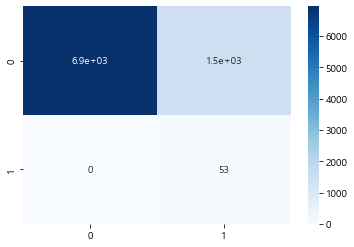

In [98]:
import seaborn as sns
sns.heatmap(a, annot=True, cmap='Blues')